<a href="https://colab.research.google.com/github/xandreiAThome/philippine-language-clustering/blob/main/language-clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Philippine Languages Clustering

### Setup


Clone the repo files and install required python libraries

In [5]:
repo = "https://github.com/xandreiAThome/philippine-language-clustering"

In [6]:
import os
import shutil

repo_name = repo.split('/')[-1]

if os.path.exists(repo_name):
    shutil.rmtree(repo_name)
    print(f"Removed existing directory: {repo_name}")

!git clone {repo}

Removed existing directory: philippine-language-clustering
Cloning into 'philippine-language-clustering'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 2), reused 6 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 4.14 KiB | 4.14 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [7]:
%cd philippine-language-clustering/

/content/philippine-language-clustering


In [8]:
!pip install -r requirements.txt

In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from rapidfuzz import process, fuzz
import seaborn as sns

This notebook explores the relationships between the different Philippine languages and some foreign languages using different computational techniques to quantify their similarity in language features.

One way to compare language similarity is to compute for the lexical similarity of the words used in the languages. We can compute for the lexical similarity of the 16 languages in our dataset against each other.

## Lexical Similarity


We will use the Levenshtein distance in order to compute the lexical similarity between two languages in our dataset. Levenshtein distance is the measure of the fewest number of single character modification that will transform one word into another (Citation needed).



First we need to transform the tsv file containing the verses of the bible in each of the 16 languages into a word list. Access the dataset in your google drive and cd to the directory.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%cd ../drive/MyDrive/ph-lang-clustering/data/Verses/

/content/drive/MyDrive/ph-lang-clustering/data/Verses


In [12]:
%ls

Bikolano.tsv   Ilokano.tsv      Mansaka.tsv      Tagalog.tsv
Cebuano.tsv    Ilonggo.tsv      Pangasinan.tsv   Tausug.tsv
Chavacano.tsv  Ivatan.tsv       Romblomanon.tsv  Waray.tsv
English.tsv    Kapampangan.tsv  Spanish.tsv      Yami.tsv


Load the tsv files into a list.

In [13]:
# Search for .tsv files in the current working directory
tsv_files = list(Path(".").glob("*.tsv"))

# Check if the list is not empty before printing
if tsv_files:
    print("Printing 3 of the the following .tsv files:")
    for i in range(min(3, len(tsv_files))):
        print(tsv_files[i].name)
else:
    print("No .tsv files found in the current directory.")

Printing 3 of the the following .tsv files:
Bikolano.tsv
Mansaka.tsv
Chavacano.tsv


### Cleaning and Processing the Data

Now that the tsv files are loaded we need to clean the data to remove any non alphabetical characters and lowercase each word. We will create a frequency table alongside the wordlist using a DataFrame.

In [14]:
lang_freq_tables = {}

for path in tqdm(tsv_files, desc="Processing languages"):
    print(f"\n📖 Processing {path}...")

    # Read file and handle missing columns
    df = pd.read_csv(path, sep="\t", dtype=str)
    if "Text" not in df.columns:
        raise ValueError(f"File {path.name} must contain a 'Text' column.")

    counter = Counter()

    # Process line by line
    for verse in df["Text"].dropna():
        words = verse.split()
        counter.update(words)

    # Save as frequency table
    wdf = pd.DataFrame(counter.items(), columns=["word", "count"])
    wdf = wdf.sort_values("count", ascending=False).reset_index(drop=True)

    # Get the language name from the filename
    lang = path.stem

    # Add the language name as a column to the dataframe
    wdf['language'] = lang

    # Add the dataframe to the dictionary with the language name as the key
    lang_freq_tables[lang] = wdf

    print(f"Processed {len(wdf)} unique words for {lang}")

Processing languages:   0%|          | 0/16 [00:00<?, ?it/s]


📖 Processing Bikolano.tsv...


Processing languages:   6%|▋         | 1/16 [00:00<00:11,  1.32it/s]

Processed 37563 unique words for Bikolano

📖 Processing Mansaka.tsv...


Processing languages:  12%|█▎        | 2/16 [00:01<00:06,  2.08it/s]

Processed 14241 unique words for Mansaka

📖 Processing Chavacano.tsv...


Processing languages:  19%|█▉        | 3/16 [00:01<00:05,  2.23it/s]

Processed 8390 unique words for Chavacano

📖 Processing Romblomanon.tsv...


Processing languages:  25%|██▌       | 4/16 [00:01<00:04,  2.53it/s]

Processed 13706 unique words for Romblomanon

📖 Processing Ivatan.tsv...


Processing languages:  31%|███▏      | 5/16 [00:02<00:03,  2.95it/s]

Processed 12461 unique words for Ivatan

📖 Processing Spanish.tsv...


Processing languages:  38%|███▊      | 6/16 [00:03<00:07,  1.38it/s]

Processed 59950 unique words for Spanish

📖 Processing English.tsv...


Processing languages:  44%|████▍     | 7/16 [00:04<00:08,  1.06it/s]

Processed 36081 unique words for English

📖 Processing Kapampangan.tsv...


Processing languages:  50%|█████     | 8/16 [00:06<00:08,  1.07s/it]

Processed 32692 unique words for Kapampangan

📖 Processing Waray.tsv...


Processing languages:  56%|█████▋    | 9/16 [00:07<00:08,  1.22s/it]

Processed 44493 unique words for Waray

📖 Processing Pangasinan.tsv...


Processing languages:  62%|██████▎   | 10/16 [00:08<00:06,  1.15s/it]

Processed 41416 unique words for Pangasinan

📖 Processing Tagalog.tsv...


Processing languages:  69%|██████▉   | 11/16 [00:09<00:05,  1.07s/it]

Processed 43432 unique words for Tagalog

📖 Processing Yami.tsv...


Processing languages:  75%|███████▌  | 12/16 [00:09<00:03,  1.23it/s]

Processed 11308 unique words for Yami

📖 Processing Cebuano.tsv...


Processing languages:  81%|████████▏ | 13/16 [00:10<00:02,  1.26it/s]

Processed 35180 unique words for Cebuano

📖 Processing Ilokano.tsv...


Processing languages:  94%|█████████▍| 15/16 [00:11<00:00,  1.97it/s]

Processed 65197 unique words for Ilokano

📖 Processing Tausug.tsv...
Processed 14361 unique words for Tausug

📖 Processing Ilonggo.tsv...


Processing languages: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]

Processed 38781 unique words for Ilonggo


In [15]:
lang_freq_tables["Tagalog"].head() # check the output freq table

,word,count,language
0,sa,64575,Tagalog
1,ng,52860,Tagalog
2,ang,44528,Tagalog
3,at,35474,Tagalog
4,mga,34469,Tagalog


We will compute for the Levenshtein distance for words between two languages. As computing for all the words for each language is too computatioally expensive, we will randomly sample a word with a limited sample sized. The average Levenshtein distance between two languages will then be the lexical similarity of the two.

In [16]:
def lexical_similarity(words_a, words_b, sample_size=3000):
    """
    Compute average Levenshtein similarity between two wordlists.
    """
    # Extract the 'word' column from the frequency tables

    # Limit to sample size for performance
    if len(words_a) > sample_size:
        words_a = np.random.choice(words_a, sample_size, replace=False)
    if len(words_b) > sample_size:
        words_b = np.random.choice(words_b, sample_size, replace=False)

    scores = []
    for w in words_a:
        best_match = process.extractOne(w, words_b, scorer=fuzz.ratio)
        if best_match:
            scores.append(best_match[1])
    return np.mean(scores)

In [25]:
langs = list(lang_freq_tables.keys())
sim_matrix = pd.DataFrame(index=langs, columns=langs, dtype=float)

for i, lang_a in tqdm(enumerate(langs), total=len(langs), desc="Calculating Similarity Matrix"):
    words_a = lang_freq_tables[lang_a]["word"].tolist() # Extract the 'word' list
    for j, lang_b in enumerate(langs):
        if i == j:
            sim_matrix.iloc[i, j] = 100.0
        else:
            words_b = lang_freq_tables[lang_b]["word"].tolist() # Extract the 'word' list
            sim = lexical_similarity(words_a, words_b, 1000)
            sim_matrix.loc[lang_a, lang_b] = sim
            print(f"{lang_a} vs {lang_b}: {sim:.2f}%")

Calculating Similarity Matrix:   0%|          | 0/16 [00:00<?, ?it/s]

Bikolano vs Mansaka: 66.25%
Bikolano vs Chavacano: 62.27%
Bikolano vs Romblomanon: 67.87%
Bikolano vs Ivatan: 65.40%
Bikolano vs Spanish: 59.57%
Bikolano vs English: 58.16%
Bikolano vs Kapampangan: 65.55%
Bikolano vs Waray: 67.88%
Bikolano vs Pangasinan: 66.43%
Bikolano vs Tagalog: 68.25%
Bikolano vs Yami: 63.38%
Bikolano vs Cebuano: 67.47%
Bikolano vs Ilokano: 65.38%
Bikolano vs Tausug: 62.76%


Calculating Similarity Matrix:   6%|▋         | 1/16 [00:07<01:57,  7.83s/it]

Bikolano vs Ilonggo: 67.10%
Mansaka vs Bikolano: 67.61%
Mansaka vs Chavacano: 63.43%
Mansaka vs Romblomanon: 67.75%
Mansaka vs Ivatan: 66.80%
Mansaka vs Spanish: 58.87%
Mansaka vs English: 58.03%
Mansaka vs Kapampangan: 66.90%
Mansaka vs Waray: 67.92%
Mansaka vs Pangasinan: 66.94%
Mansaka vs Tagalog: 67.35%
Mansaka vs Yami: 65.81%
Mansaka vs Cebuano: 68.31%
Mansaka vs Ilokano: 65.81%
Mansaka vs Tausug: 66.63%


Calculating Similarity Matrix:  12%|█▎        | 2/16 [00:17<02:00,  8.64s/it]

Mansaka vs Ilonggo: 67.88%
Chavacano vs Bikolano: 61.85%
Chavacano vs Mansaka: 61.55%
Chavacano vs Romblomanon: 62.32%
Chavacano vs Ivatan: 62.84%
Chavacano vs Spanish: 67.92%
Chavacano vs English: 63.37%
Chavacano vs Kapampangan: 62.64%
Chavacano vs Waray: 61.12%
Chavacano vs Pangasinan: 61.65%
Chavacano vs Tagalog: 60.94%
Chavacano vs Yami: 59.46%
Chavacano vs Cebuano: 61.62%
Chavacano vs Ilokano: 60.61%
Chavacano vs Tausug: 56.54%


Calculating Similarity Matrix:  19%|█▉        | 3/16 [00:25<01:52,  8.67s/it]

Chavacano vs Ilonggo: 61.01%
Romblomanon vs Bikolano: 67.76%
Romblomanon vs Mansaka: 66.42%
Romblomanon vs Chavacano: 62.19%
Romblomanon vs Ivatan: 65.41%
Romblomanon vs Spanish: 58.66%
Romblomanon vs English: 56.60%
Romblomanon vs Kapampangan: 64.48%
Romblomanon vs Waray: 68.71%
Romblomanon vs Pangasinan: 65.36%
Romblomanon vs Tagalog: 67.41%
Romblomanon vs Yami: 62.94%
Romblomanon vs Cebuano: 69.00%
Romblomanon vs Ilokano: 64.96%
Romblomanon vs Tausug: 65.16%


Calculating Similarity Matrix:  25%|██▌       | 4/16 [00:33<01:40,  8.41s/it]

Romblomanon vs Ilonggo: 68.82%
Ivatan vs Bikolano: 65.63%
Ivatan vs Mansaka: 66.15%
Ivatan vs Chavacano: 62.72%
Ivatan vs Romblomanon: 64.98%
Ivatan vs Spanish: 59.19%
Ivatan vs English: 57.85%
Ivatan vs Kapampangan: 64.12%
Ivatan vs Waray: 64.89%
Ivatan vs Pangasinan: 65.85%
Ivatan vs Tagalog: 64.60%
Ivatan vs Yami: 68.10%
Ivatan vs Cebuano: 64.71%
Ivatan vs Ilokano: 63.89%
Ivatan vs Tausug: 62.58%


Calculating Similarity Matrix:  31%|███▏      | 5/16 [00:43<01:36,  8.76s/it]

Ivatan vs Ilonggo: 63.94%
Spanish vs Bikolano: 59.13%
Spanish vs Mansaka: 57.19%
Spanish vs Chavacano: 66.83%
Spanish vs Romblomanon: 57.95%
Spanish vs Ivatan: 59.11%
Spanish vs English: 61.26%
Spanish vs Kapampangan: 58.60%
Spanish vs Waray: 57.19%
Spanish vs Pangasinan: 58.53%
Spanish vs Tagalog: 57.18%
Spanish vs Yami: 55.59%
Spanish vs Cebuano: 57.36%
Spanish vs Ilokano: 56.26%
Spanish vs Tausug: 52.35%


Calculating Similarity Matrix:  38%|███▊      | 6/16 [00:50<01:24,  8.41s/it]

Spanish vs Ilonggo: 57.27%
English vs Bikolano: 57.96%
English vs Mansaka: 55.53%
English vs Chavacano: 62.21%
English vs Romblomanon: 56.85%
English vs Ivatan: 57.50%
English vs Spanish: 60.74%
English vs Kapampangan: 57.73%
English vs Waray: 57.14%
English vs Pangasinan: 57.92%
English vs Tagalog: 56.65%
English vs Yami: 55.36%
English vs Cebuano: 56.95%
English vs Ilokano: 56.38%
English vs Tausug: 51.68%


Calculating Similarity Matrix:  44%|████▍     | 7/16 [01:00<01:18,  8.70s/it]

English vs Ilonggo: 57.17%
Kapampangan vs Bikolano: 66.54%
Kapampangan vs Mansaka: 65.60%
Kapampangan vs Chavacano: 62.42%
Kapampangan vs Romblomanon: 65.74%
Kapampangan vs Ivatan: 64.90%
Kapampangan vs Spanish: 60.12%
Kapampangan vs English: 59.66%
Kapampangan vs Waray: 65.92%
Kapampangan vs Pangasinan: 66.86%
Kapampangan vs Tagalog: 67.51%
Kapampangan vs Yami: 63.16%
Kapampangan vs Cebuano: 66.84%
Kapampangan vs Ilokano: 64.64%
Kapampangan vs Tausug: 65.33%


Calculating Similarity Matrix:  50%|█████     | 8/16 [01:09<01:11,  8.90s/it]

Kapampangan vs Ilonggo: 66.65%
Waray vs Bikolano: 67.90%
Waray vs Mansaka: 65.37%
Waray vs Chavacano: 60.59%
Waray vs Romblomanon: 68.30%
Waray vs Ivatan: 63.73%
Waray vs Spanish: 57.74%
Waray vs English: 56.96%
Waray vs Kapampangan: 64.63%
Waray vs Pangasinan: 65.20%
Waray vs Tagalog: 67.08%
Waray vs Yami: 62.88%
Waray vs Cebuano: 68.61%
Waray vs Ilokano: 64.97%
Waray vs Tausug: 63.69%


Calculating Similarity Matrix:  56%|█████▋    | 9/16 [01:17<00:59,  8.52s/it]

Waray vs Ilonggo: 67.69%
Pangasinan vs Bikolano: 66.28%
Pangasinan vs Mansaka: 65.44%
Pangasinan vs Chavacano: 62.25%
Pangasinan vs Romblomanon: 64.53%
Pangasinan vs Ivatan: 65.62%
Pangasinan vs Spanish: 58.88%
Pangasinan vs English: 58.57%
Pangasinan vs Kapampangan: 66.43%
Pangasinan vs Waray: 65.18%
Pangasinan vs Tagalog: 65.46%
Pangasinan vs Yami: 64.74%
Pangasinan vs Cebuano: 65.96%
Pangasinan vs Ilokano: 65.66%
Pangasinan vs Tausug: 63.02%


Calculating Similarity Matrix:  62%|██████▎   | 10/16 [01:26<00:53,  8.88s/it]

Pangasinan vs Ilonggo: 65.24%
Tagalog vs Bikolano: 68.54%
Tagalog vs Mansaka: 65.63%
Tagalog vs Chavacano: 61.71%
Tagalog vs Romblomanon: 67.41%
Tagalog vs Ivatan: 65.03%
Tagalog vs Spanish: 57.77%
Tagalog vs English: 57.94%
Tagalog vs Kapampangan: 67.39%
Tagalog vs Waray: 67.83%
Tagalog vs Pangasinan: 66.90%
Tagalog vs Yami: 63.40%
Tagalog vs Cebuano: 68.09%
Tagalog vs Ilokano: 65.26%
Tagalog vs Tausug: 65.22%


Calculating Similarity Matrix:  69%|██████▉   | 11/16 [01:35<00:43,  8.71s/it]

Tagalog vs Ilonggo: 67.71%
Yami vs Bikolano: 63.02%
Yami vs Mansaka: 65.06%
Yami vs Chavacano: 58.83%
Yami vs Romblomanon: 62.75%
Yami vs Ivatan: 68.07%
Yami vs Spanish: 57.91%
Yami vs English: 56.20%
Yami vs Kapampangan: 62.96%
Yami vs Waray: 62.97%
Yami vs Pangasinan: 64.75%
Yami vs Tagalog: 63.89%
Yami vs Cebuano: 63.37%
Yami vs Ilokano: 62.55%
Yami vs Tausug: 60.73%


Calculating Similarity Matrix:  75%|███████▌  | 12/16 [01:43<00:34,  8.66s/it]

Yami vs Ilonggo: 61.68%
Cebuano vs Bikolano: 67.89%
Cebuano vs Mansaka: 66.11%
Cebuano vs Chavacano: 62.44%
Cebuano vs Romblomanon: 68.64%
Cebuano vs Ivatan: 64.71%
Cebuano vs Spanish: 58.57%
Cebuano vs English: 58.70%
Cebuano vs Kapampangan: 65.44%
Cebuano vs Waray: 69.02%
Cebuano vs Pangasinan: 65.83%
Cebuano vs Tagalog: 67.65%
Cebuano vs Yami: 63.18%
Cebuano vs Ilokano: 65.12%
Cebuano vs Tausug: 64.64%


Calculating Similarity Matrix:  81%|████████▏ | 13/16 [01:53<00:26,  8.88s/it]

Cebuano vs Ilonggo: 68.99%
Ilokano vs Bikolano: 64.87%
Ilokano vs Mansaka: 63.34%
Ilokano vs Chavacano: 60.17%
Ilokano vs Romblomanon: 64.49%
Ilokano vs Ivatan: 63.85%
Ilokano vs Spanish: 57.89%
Ilokano vs English: 55.88%
Ilokano vs Kapampangan: 63.37%
Ilokano vs Waray: 64.76%
Ilokano vs Pangasinan: 64.68%
Ilokano vs Tagalog: 64.63%
Ilokano vs Yami: 61.91%
Ilokano vs Cebuano: 64.60%
Ilokano vs Tausug: 62.34%


Calculating Similarity Matrix:  88%|████████▊ | 14/16 [02:00<00:17,  8.56s/it]

Ilokano vs Ilonggo: 64.45%
Tausug vs Bikolano: 64.72%
Tausug vs Mansaka: 66.57%
Tausug vs Chavacano: 59.91%
Tausug vs Romblomanon: 65.51%
Tausug vs Ivatan: 61.58%
Tausug vs Spanish: 55.95%
Tausug vs English: 55.99%
Tausug vs Kapampangan: 66.24%
Tausug vs Waray: 64.92%
Tausug vs Pangasinan: 64.06%
Tausug vs Tagalog: 65.91%
Tausug vs Yami: 61.68%
Tausug vs Cebuano: 65.23%
Tausug vs Ilokano: 63.61%


Calculating Similarity Matrix:  94%|█████████▍| 15/16 [02:10<00:08,  8.86s/it]

Tausug vs Ilonggo: 66.34%
Ilonggo vs Bikolano: 68.06%
Ilonggo vs Mansaka: 67.09%
Ilonggo vs Chavacano: 62.18%
Ilonggo vs Romblomanon: 69.31%
Ilonggo vs Ivatan: 64.24%
Ilonggo vs Spanish: 58.95%
Ilonggo vs English: 57.75%
Ilonggo vs Kapampangan: 66.45%
Ilonggo vs Waray: 68.73%
Ilonggo vs Pangasinan: 65.97%
Ilonggo vs Tagalog: 68.38%
Ilonggo vs Yami: 63.10%
Ilonggo vs Cebuano: 70.29%
Ilonggo vs Ilokano: 65.57%


Calculating Similarity Matrix: 100%|██████████| 16/16 [02:19<00:00,  8.72s/it]

Ilonggo vs Tausug: 65.05%


Though this will not be a 100% accurate similarity matrix because it is only a sample of each languages, it can give a general idea on the lexical similarity between each of the languages. And increasing the sample size will increase the accuracy of the score. You can see that the same comparison Between Language A and B may result on different results precisely because of the random sampling.

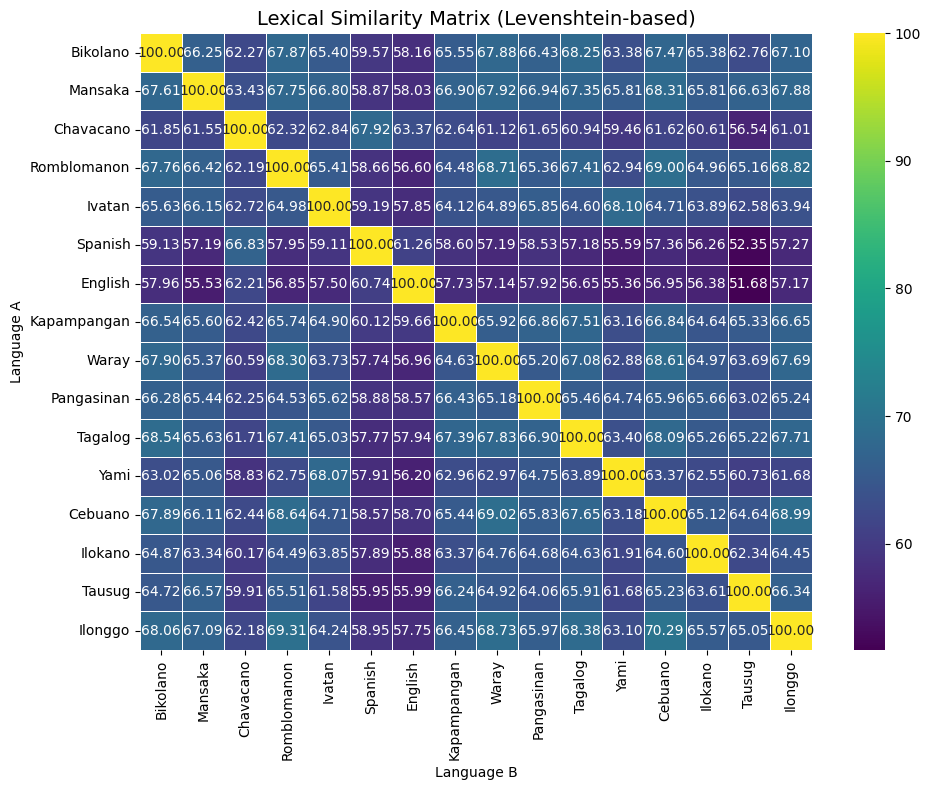

In [26]:

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix.astype(float), annot=True, cmap="viridis", fmt=".2f", linewidths=.5)
plt.title("Lexical Similarity Matrix (Levenshtein-based)", fontsize=14)
plt.xlabel("Language B")
plt.ylabel("Language A")
plt.tight_layout()
plt.show()